## Dataset: A databank for intracellular electrophysiological mapping of the adult somatosensory cortex

See https://github.com/OpenSourceBrain/NWBShowcase/issues/5

170502_AL_257_CC.mat  180817_ME_9_CC.mat		    README.md
171222_NC_162_FN.mat  LantyerEtAl2018.170502_AL_257_CC.nwb  TestData.ipynb
Contents of MAT file 180817_ME_9_CC.mat: ['Trace_9_1_10_1', 'Trace_9_1_10_2', 'Trace_9_1_1_1', 'Trace_9_1_1_2', 'Trace_9_1_2_1', 'Trace_9_1_2_2', 'Trace_9_1_3_1', 'Trace_9_1_3_2', 'Trace_9_1_4_1', 'Trace_9_1_4_2', 'Trace_9_1_5_1', 'Trace_9_1_5_2', 'Trace_9_1_6_1', 'Trace_9_1_6_2', 'Trace_9_1_7_1', 'Trace_9_1_7_2', 'Trace_9_1_8_1', 'Trace_9_1_8_2', 'Trace_9_1_9_1', 'Trace_9_1_9_2', '__globals__', '__header__', '__version__']


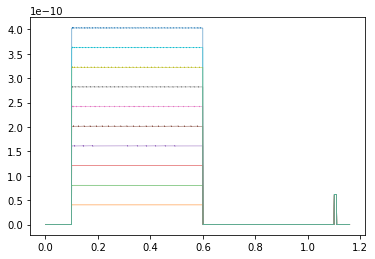

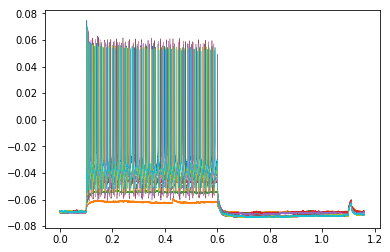

Contents of MAT file 170502_AL_257_CC.mat: ['Trace_2_1_10_1', 'Trace_2_1_10_2', 'Trace_2_1_1_1', 'Trace_2_1_1_2', 'Trace_2_1_2_1', 'Trace_2_1_2_2', 'Trace_2_1_3_1', 'Trace_2_1_3_2', 'Trace_2_1_4_1', 'Trace_2_1_4_2', 'Trace_2_1_5_1', 'Trace_2_1_5_2', 'Trace_2_1_6_1', 'Trace_2_1_6_2', 'Trace_2_1_7_1', 'Trace_2_1_7_2', 'Trace_2_1_8_1', 'Trace_2_1_8_2', 'Trace_2_1_9_1', 'Trace_2_1_9_2', 'Trace_2_2_10_1', 'Trace_2_2_10_2', 'Trace_2_2_1_1', 'Trace_2_2_1_2', 'Trace_2_2_2_1', 'Trace_2_2_2_2', 'Trace_2_2_3_1', 'Trace_2_2_3_2', 'Trace_2_2_4_1', 'Trace_2_2_4_2', 'Trace_2_2_5_1', 'Trace_2_2_5_2', 'Trace_2_2_6_1', 'Trace_2_2_6_2', 'Trace_2_2_7_1', 'Trace_2_2_7_2', 'Trace_2_2_8_1', 'Trace_2_2_8_2', 'Trace_2_2_9_1', 'Trace_2_2_9_2', 'Trace_2_3_10_1', 'Trace_2_3_10_2', 'Trace_2_3_1_1', 'Trace_2_3_1_2', 'Trace_2_3_2_1', 'Trace_2_3_2_2', 'Trace_2_3_3_1', 'Trace_2_3_3_2', 'Trace_2_3_4_1', 'Trace_2_3_4_2', 'Trace_2_3_5_1', 'Trace_2_3_5_2', 'Trace_2_3_6_1', 'Trace_2_3_6_2', 'Trace_2_3_7_1', 'Trace_2_3_7_2'

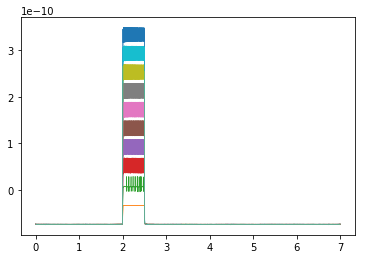

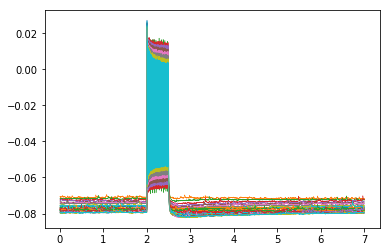

In [1]:
!ls

import matplotlib.pyplot as plt
%matplotlib inline 

import scipy.io as sio


all_datarefs = ['180817_ME_9_CC','170502_AL_257_CC']

for data_ref in all_datarefs:

    mat_file = '%s.mat'%data_ref
    mat_contents = sio.loadmat(mat_file)

    print('Contents of MAT file %s: %s'%(mat_file, sorted(mat_contents.keys())))

    key_set = sorted(mat_contents.keys())

    for t in key_set:
        if 'Trace_' in t and t.endswith('_1'):
            #print('Current injection trace: %s'%t)
            trace = mat_contents[t].T

            plt.plot(trace[0],trace[1], lw=.5, label='%s'%t)

    plt.figure()
    for t in key_set:
        if 'Trace_' in t and t.endswith('_2'):
            #print('Response trace: %s'%t)
            trace = mat_contents[t].T

            plt.plot(trace[0],trace[1], lw=.5, label='%s'%t)

        
    plt.show()
        


In [2]:
from datetime import datetime

from dateutil.tz import tzlocal
import pynwb
import math
from hdmf.backends.hdf5.h5_utils import H5DataIO

print('Using pynwb v%s'%pynwb.__version__)

for data_ref in all_datarefs:

    mat_file = '%s.mat'%data_ref
    mat_contents = sio.loadmat(mat_file)

    start_time = datetime(2019, 1, 1, 11, tzinfo=tzlocal())
    create_date = datetime.now(tz=tzlocal())

    experimenter = 'Angelica da Silva Lantyer' if 'AL' in data_ref else \
                   ('Niccolò Calcini' if 'NC' in data_ref else \
                    ('Melanie Emmelkamp' if 'ME' in data_ref else '???'))

    main_ref = 'Lantyer et al. dataset taken from file %s.mat'%data_ref
    nwbfile = pynwb.NWBFile(main_ref, 
                      main_ref, 
                      start_time,
                      file_create_date=create_date,
                      notes='NWB file created with pynwb v%s'%pynwb.__version__,
                      experimenter=experimenter,
                      experiment_description='A databank for intracellular electrophysiological mapping of the adult somatosensory cortex',
                      institution='Donders Institute for Brain, Cognition and Behaviour, Radboud University')


    for t in mat_contents.keys():
        if 'Trace_' in t:
            print('Adding trace: %s'%t)
            trace = mat_contents[t].T

            #plt.plot(trace[0],trace[1], lw=.5, label='%s'%t)

            timestamps = trace[0]
            data = trace[1]

            comments='Extracted from MAT file: %s.mat'%data_ref
            
            wrapped_data = H5DataIO(data=data, compression=True) 
            #wrapped_data = data 

            if t.endswith('_1'):
                ts_stim = pynwb.TimeSeries('%s'%t, wrapped_data, 'A', timestamps=timestamps,comments=comments,
                                          description='Membrane potential')
                nwbfile.add_stimulus(ts_stim)
            if t.endswith('_2'):
                ts_acq = pynwb.TimeSeries('%s'%t, wrapped_data, 'V', timestamps=timestamps,comments=comments,
                                         description='Applied current')
                nwbfile.add_acquisition(ts_acq)


    nwb_file_name = 'LantyerEtAl2018.%s.nwb'%(data_ref)
    io = pynwb.NWBHDF5IO(nwb_file_name, mode='w')
    io.write(nwbfile)
    io.close()
    print("Written NWB file to %s"%nwb_file_name)

Using pynwb v1.0.3
Adding trace: Trace_9_1_1_1
Adding trace: Trace_9_1_1_2
Adding trace: Trace_9_1_2_1
Adding trace: Trace_9_1_2_2
Adding trace: Trace_9_1_3_1
Adding trace: Trace_9_1_3_2
Adding trace: Trace_9_1_4_1
Adding trace: Trace_9_1_4_2
Adding trace: Trace_9_1_5_1
Adding trace: Trace_9_1_5_2
Adding trace: Trace_9_1_6_1
Adding trace: Trace_9_1_6_2
Adding trace: Trace_9_1_7_1
Adding trace: Trace_9_1_7_2
Adding trace: Trace_9_1_8_1
Adding trace: Trace_9_1_8_2
Adding trace: Trace_9_1_9_1
Adding trace: Trace_9_1_9_2
Adding trace: Trace_9_1_10_1
Adding trace: Trace_9_1_10_2
Written NWB file to LantyerEtAl2018.180817_ME_9_CC.nwb
Adding trace: Trace_2_1_10_1
Adding trace: Trace_2_1_10_2
Adding trace: Trace_2_1_1_1
Adding trace: Trace_2_1_1_2
Adding trace: Trace_2_1_2_1
Adding trace: Trace_2_1_2_2
Adding trace: Trace_2_1_3_1
Adding trace: Trace_2_1_3_2
Adding trace: Trace_2_1_4_1
Adding trace: Trace_2_1_4_2
Adding trace: Trace_2_1_5_1
Adding trace: Trace_2_1_5_2
Adding trace: Trace_2_1_6_